# Example from Sorensen and Chaturantabut

$$ f(x,\mu) = (1-x) \cos{(3\pi\mu(x+1)))\exp{(-(1+x)\mu)}}$$

With $x\in [-1,+1]$ and $\mu\in[1,pi]$

In [170]:
import numpy as np
import matplotlib.pyplot as plt

## Generate samples and snapshots

In [171]:
x = np.linspace(-1,1,200)

np.random.seed(123456789)
n_samples = 50
n_train = 40
n_test = n_samples-n_train

samples = np.random.uniform(low=1, high=np.pi,size=n_samples)
print(samples)

[2.14111129 2.14390302 2.09125504 2.52816349 1.55038707 2.6119631
 2.89290917 1.33173074 2.43603733 2.37799742 2.54971463 2.60346439
 2.75299509 1.20968017 1.00761102 1.49430018 1.0262455  1.75714233
 1.39679745 2.69778699 2.31102311 2.92621081 1.67538932 1.87089031
 3.09931462 2.16088281 1.51889636 1.54019893 2.21033348 1.28555328
 2.87658889 2.02867517 1.6067686  2.91075205 2.77245055 3.09869756
 2.85725976 1.41441028 1.97333389 2.72437353 2.60026531 2.97017897
 1.47215678 3.13720902 2.2909446  1.07606607 2.18969986 1.68454408
 2.07530358 2.14172955]


In [172]:
f = lambda mu: (1-x)*np.cos((3*np.pi*mu*(1+x)))*np.exp(-(x+1)*mu)

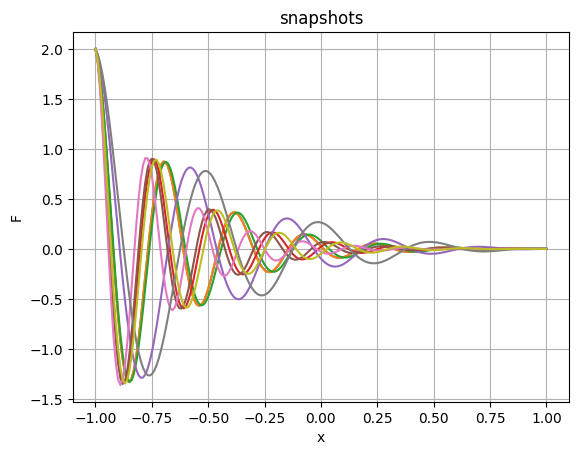

In [173]:
snapshots = np.zeros((len(x),n_samples))
for i,mu_ in enumerate(samples):
    snapshots[:,i]=f(mu=mu_)

plt.figure()
for i in range(9):
    plt.plot(x,snapshots[:,i])
plt.xlabel('x')
plt.ylabel('F')
plt.title('snapshots')
plt.grid(True)

# SVD

The approximation from projecting $F(\mu)$ onto the subspace spanned by the basis $\{u_1, . . . , u_m\}$ is of the form
$$ F(\mu) = U c(\mu)$$

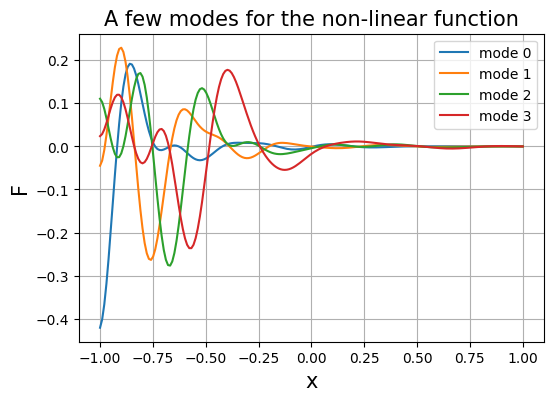

In [174]:
U_all, S, _ = np.linalg.svd(snapshots[:,:n_train],full_matrices=False,compute_uv=True)

plt.figure(figsize=(6,4))
plt.semilogy(S/np.max(S),'-+')
plt.xlabel('snapshot ID',fontsize=15)
plt.ylabel('sing. values',fontsize=15)
plt.title('singular values for F',fontsize=15)
plt.tight_layout()
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
for i in range(4):
    plt.plot(x,U_all[:,i],label='mode '+str(i))
    plt.grid(True)
    plt.legend()
    plt.title('A few modes for the non-linear function',fontsize=15)
plt.xlabel('x',fontsize=15)
plt.ylabel('F',fontsize=15)
plt.show()

### select rank

In [198]:
rk = 10
U = U_all[:,:rk]

## Explanation
The approximation from projecting $F(\mu)$ onto the subspace spanned by the basis $\{u_1, . . . , u_m\}$ is of the form
$$ F(\mu) = U c(\mu)$$

To determine $c(\mu)$, we select $m$ distinct rows from the overdetermined system $ F(\mu) = U c(\mu)$

We select a selector matrix $P$ of size $N\times m$ that will extract certains rows:
$$P = [e_{\varrho_1}, \ldots, e_{\varrho_m}]$$
with 
$$e_{\varrho_k} = [0,\ldots, 0,1,0,\ldots,0]^T$$ 
where the $\varrho_k$ entry is 1 while all others are 0.

With $P$ at hand, we then determine the coefficients by solving 
$$P^T F(\mu) = P^T U c(\mu)$$
This is an $m times m$ system.

Finally, the approximation of $F$, for all rows, is
$$
F(\mu) = U c(\mu) = U \left( (P^T U)^{-1} P^T F(\mu)\right)
$$

This is indeed an **interpolation** at those $m$ rows as the following is true:
$$
P^T F(\mu) = P^T U  (P^T U)^{-1} P^T F(\mu)
$$

There is only one last item to discuss: how to select these $m$ rows??
- we proceed iteratively. 
- We select the first basis $u_1$. 
  - The first index will simply be the location of the maximum of $|u_1|$
  - Now $P$ has one column
- Next, we compute the residual $r$ between $u_2$ and the already selected basis, only $u_1$ for now
  $$ r = u_2 - U c= u_2 - u_1 c$$
  - What is $c$?  $c$ is chosen such that $P^T u_1 c = P^T u_2$ or $u_1(\varrho_1) c = u_1(\varrho_1)$
  - The term $r$ can be viewed as the residual or the error between the input basis $u_\ell$ and its approximation $Uc$ from    interpolating the basis $\{u_1, \ldots, u_{\ell−1}\}$ at the indices $\varrho_1, \ldots, \varrho_{\ell-1}$

In [199]:
def DEIM_SVD(u_in, verbose=False):
    [n, r] = np.shape(u_in)
    print("length F ={}, selected rank={}\n".format(n,r))
    P, list_ind = np.zeros([n,r]), np.zeros(r,dtype=int)
    
    ind = np.argmax(np.abs(u_in[:, 0]))
    
    if verbose:
        print('DEIM Cycle: ', 0)
        
    P[ind,0] = 1
    BB = np.expand_dims(u_in[:,0],axis=1)
    list_ind[0]= ind
    
    for i in range(1,r):
        if verbose:
            print('DEIM Cycle: ', i)
        P_loc, u_i = P[:,:i], u_in[:,i]        
        mat = P_loc.T @ BB
        rhs = P_loc.T @ u_i
        c = np.linalg.solve(mat, rhs)
        residual = u_i - BB@c
        ind = np.argmax(np.abs(residual))
        BB = np.hstack((BB, np.expand_dims(u_i,axis=1)))
        P[ind,i] = 1
        list_ind[i] = ind
    print("indices =",list_ind)
    phi = np.sort(list_ind[:r]).astype(int)
    P2 = np.zeros([n,r])
    for j,i in enumerate(phi):
        P2[i,j]=1
    
    return P[:,:r],list_ind

In [200]:
P, list_ind = DEIM_SVD(U)

plt.figure()
plt.spy(P,markersize=5)
plt.show()

length F =200, selected rank=10

indices = [  0  24  32  42  51  76  85 108 117   8]


### doing it by hand
1. we plot the first basis vector for $F$ and look where it is the largest in magnitude

At that position is where we will evaluate the nonlinear function in the future

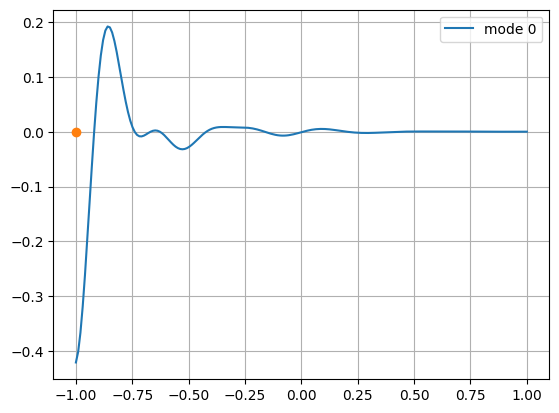

In [201]:
ind = np.argmax(np.abs(U[:,0]))

plt.figure()
plt.plot(x,U[:,0],label='mode '+str(0))
plt.plot(x[ind],0,'o')
plt.grid(True)
plt.legend()
plt.show()

The action of $P^T$ (currently one colum of $P$ since we are looking at the first vector only) on the basis $V[:,0]$ will simply extract the value of that basis at that index.

In [202]:
print("P[:,0].T @ U[:,0] = ",P[:,0].T @ U[:,0])

P[:,0].T @ U[:,0] =  -0.421038004493644


### let's pick two samples
One in the training set and one in the testing set

In [210]:
my_samples = [5,45]

In [212]:
ind = list_ind[0]
vals = snapshots[ind,my_samples]

mat = P[:,0].T @ U[:,0]

for sample in my_samples:
    plt.figure()
    plt.plot(x,snapshots[:,sample],label='truth-'+str(sample))

    rhs = snapshots[ind,sample]
    c = rhs/mat
    plt.plot(x,U[:,0]*c,'--',label='approx-'+str(my_samples[0]))

    plt.legend()
    plt.grid(True)
    plt.show()

2. Next, we look at the second vector of the basis for $F$. If we include that second vector

In [213]:
plt.figure()
plt.plot(x,U[:,0],label='mode '+str(0))
plt.plot(x,U[:,1],label='mode '+str(1))
plt.plot(x[list_ind[:2]],np.zeros(2),'o',ms=5)
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
c = U[list_ind[0],1] / U[list_ind[0],0] 
print("c=",c)
plt.plot(x,U[:,1]-U[:,0]*c)
plt.plot(x[list_ind[:2]],np.zeros(2),'o',ms=5)
plt.grid(True)
plt.title('we interpolate at one point and have the largest difference at the other')
plt.show()

c= 0.10653958179746972


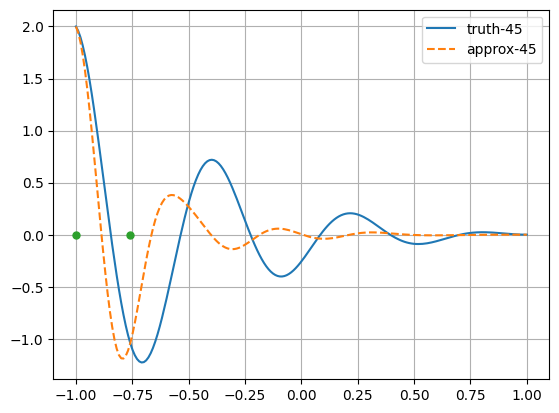

In [214]:
ind = list_ind[:2]

mat = P[:,:2].T @ U[:,:2]

for sample in my_samples:
    plt.figure()
    plt.plot(x,snapshots[:,sample],label='truth-'+str(sample))
    rhs = snapshots[ind,sample]
    c = np.linalg.solve(mat,rhs)
    plt.plot(x,U[:,:2]@c,'--',label='approx-'+str(sample))
    plt.plot(x[list_ind[:2]],np.zeros(2),'o',ms=5)
    plt.legend()
    plt.grid(True)
    plt.show()

### jumping ahead

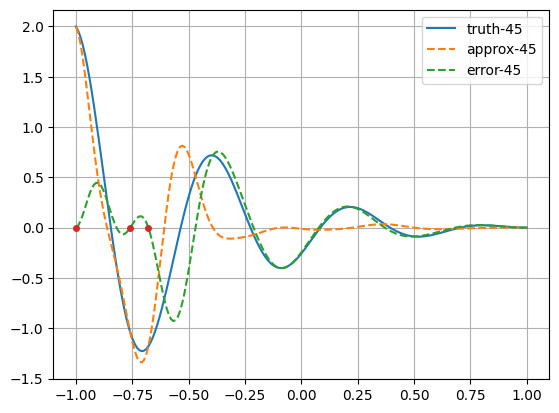

In [215]:
ind = list_ind[:3]

mat = P[:,:3].T @ U[:,:3]

for sample in my_samples:
    plt.figure()
    plt.plot(x,snapshots[:,sample],label='truth-'+str(sample))
    rhs = snapshots[ind,sample]
    c = np.linalg.solve(mat,rhs)
    plt.plot(x,U[:,:3]@c,'--',label='approx-'+str(sample))
    plt.plot(x,snapshots[:,sample]-U[:,:3]@c,'--',label='error-'+str(sample))
    plt.plot(x[list_ind[:3]],np.zeros(3),'o',ms=4)
    plt.legend()
    plt.grid(True)
    plt.show()

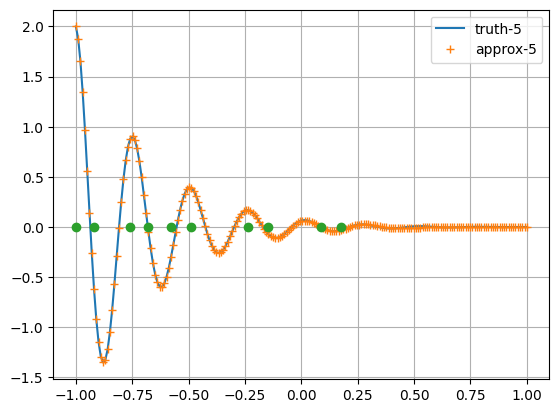

In [217]:
ind = list_ind[:]

mat = P.T @ U

for sample in my_samples:
    plt.figure()
    plt.plot(x,snapshots[:,sample],label='truth-'+str(sample))

    rhs = snapshots[ind,sample]
    c = np.linalg.solve(mat,rhs)
    plt.plot(x,U@c,'+',label='approx-'+str(sample))
    # plt.plot(x,snapshots[:,sample]-U@c,'--',label='error-'+str(sample))

    plt.plot(x[list_ind],np.zeros(len(list_ind)),'o')
    plt.legend()
    plt.grid(True)
    plt.show()

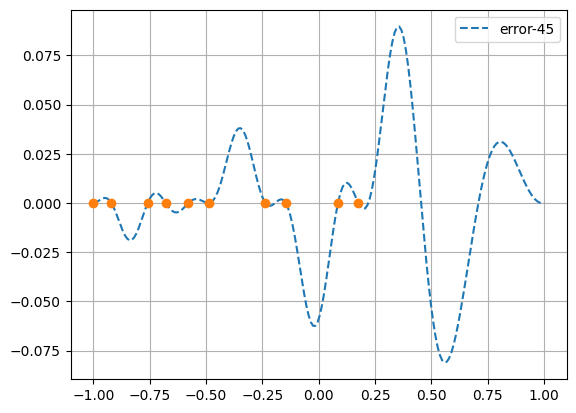

In [218]:
ind = list_ind[:]

mat = P.T @ U

for sample in my_samples:
    plt.figure()

    rhs = snapshots[ind,sample]
    c = np.linalg.solve(mat,rhs)
    plt.plot(x,snapshots[:,sample]-U@c,'--',label='error-'+str(sample))

    plt.plot(x[list_ind],np.zeros(len(list_ind)),'o')
    plt.legend()
    plt.grid(True)
    plt.show()

## Back to ROM for  nonlinear PDEs

Now that we understand that the approximation of $F$, for all rows, is
$$
F(\mu) = U_F c_F(\mu) = U_F \left( (P^T U_F)^{-1} P^T F(\mu)\right)
$$
and that this approximation **ONLY** requires to evaluate $F(\mu)$ at $m$ rows (so it's cheap), we can finish the discussion on how to include DEIM in a nonlinear problem whose FOM is:
$$ A(T) + F(T) - q = 0$$
and whose ROM is:
$$ U_T^T A(T) U_T c_T + U_T^T F(T) - U_T^t q = 0$$
where  $U_T^T F(T)$ is evaluated as
$$U_T^T F(T) = U_T^T U_F (P^T U_F)^{-1} P^T F(T)$$
- $M=U_T^T U_F (P^T U_F)^{-1}$ is pre-computed once for all
- $P^T F(T)$ is evaluated for $m$ row of $F(T)$ on the fly